<a href="https://www.kaggle.com/code/rubanzasilva/fastai-neural-network-gradient-boosting?scriptVersionId=189392513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Binary Classification of Insurance Cross 

The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

A company that has been offering health insurance to a segment of customers wants to find out whether their health insurance customers are willing to also get/sign up for their motor vehicle insurance plan 

## Library Imports

In [1]:
%pip install catboost
%pip install optuna
%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install -q -U autogluon.tabular
#%pip install autogluon
#ip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [3]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score



#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from scipy.stats import trim_mean

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp



#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#from IPython.display import FileLink

In [5]:
!ls /kaggle/input/

playground-series-s4e7


In [6]:
path = Path('/kaggle/input/playground-series-s4e7/')
path

Path('/kaggle/input/playground-series-s4e7')

In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('/kaggle/input/academic-success-dataset/data.csv',delimiter=';')

In [8]:
train_df.shape,test_df.shape

((11504798, 11), (7669866, 10))

## Subset

In [9]:
train_subset = train_df.sample(n=1000000,replace=False)
test_subset = test_df.sample(n=500000,replace=False)

In [ ]:
train_subset.shape,test_subset.shape

In [ ]:
#cont_names,cat_names = cont_cat_split(train_subset, dep_var='Response')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
#to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
#                  cat_names = cat_names,
#                  cont_names = cont_names,
#                  y_names='Response',
#                  y_block=CategoryBlock(),
#                  splits=splits)
#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_subset)
#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

# Full Dataset

Below i use the fastai cont_cat_split which returns the values of a particular dataframe as either categorical or continous values depending on the cardinality of the column values which is how many levels a particular column has.

This function takes an argument of max_card whose default is 20. If the number of unique values is above the max_card, then that variables is considered to be continuos and vice versa.

In [10]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Response')
len(cat_names),len(cont_names)

(5, 5)

In [11]:
cont_names

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [12]:
cat_names

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

Below, i use fastai's RandomSplitter to divide my dataset into a train and validation set, in this example it creates a validation set with 20% of the training dataset.


In [13]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

Below i build a TabularPandas Object which is a subclass of the Tabular class that has methods we can use to handle tabular data preparation and preprocessing.

This object takes in arguments where i define my training dataset and preprocessing steps i.e. Categorify, FillMissing,Normalize.

We also define our categorical and continuous variables resulting from the cont_cat_split.
Furthermore, i define my Target variable, the y which in this case is Response, y_block represents the type of problem.

Lastly we have the splits argument which was defined above and represents the dataset split.

In [14]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Response',
                   y_block=CategoryBlock(),
                   splits=splits)

In [15]:
to.xs.iloc[:2]

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
3321034,2,2,1,2,2,-0.825867,-1.417947,0.130413,0.732322,-0.786311
8422000,1,2,1,2,2,-0.492411,-1.802805,-0.511315,0.732322,-0.786311


In [16]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [17]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [18]:
dls.show_batch()

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,1,1,< 1 Year,No,26.000000,36.0,32254.999993,151.999998,290.000004,0
1,Female,1,0,< 1 Year,Yes,22.000001,8.0,47414.999120,151.999998,246.000001,0
2,Male,1,1,< 1 Year,No,24.000000,14.0,2629.999079,151.999998,78.999999,0
3,Male,1,0,< 1 Year,Yes,23.000001,45.0,18047.999980,151.999998,110.999998,0
4,Male,1,0,1-2 Year,Yes,37.000000,10.0,24744.000139,124.000000,103.000002,0
5,Male,1,1,1-2 Year,No,27.000000,28.0,50987.999259,26.000001,269.000003,0
6,Female,1,1,< 1 Year,No,27.000000,13.0,24391.999841,151.999998,22.000000,0
7,Male,1,0,> 2 Years,Yes,33.000000,28.0,34181.000045,124.000000,228.999998,0
8,Female,1,0,1-2 Year,Yes,59.000000,19.0,33913.000119,26.000001,251.000000,1
9,Female,1,0,< 1 Year,Yes,23.000001,30.0,30139.000005,151.999998,215.000002,1


# Exploratory Data Analysis

Below are the feature descriptions as described in this [notebook](https://www.kaggle.com/code/satyaprakashshukl/insurance-boost-analysis)

Gender: Categorical variable indicating the gender of the customer.

Age: Numeric variable indicating the age of the customer.

Driving_License: Binary variable indicating if the customer has a driving license (1 if yes, 0 if no).

Region_Code: Numeric variable indicating the region code of the customer.

Previously_Insured: Binary variable indicating if the customer was previously insured (1 if yes, 0 if no).

Vehicle_Age: Categorical variable indicating the age of the vehicle.

Vehicle_Damage: Categorical variable indicating if the vehicle was damaged in the past.

Annual_Premium: Numeric variable indicating the annual premium amount.

Policy_Sales_Channel: Numeric variable indicating the sales channel of the policy.

Vintage: Numeric variable indicating the number of days the customer has been associated with the company.

Response: Binary target variable indicating if the customer responded positively to the automobile insurance offer (1 if yes, 0 if no).

### Summary Statistics

In [19]:
train_df.shape,test_df.shape

((11504798, 11), (7669866, 10))

In [20]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [21]:
cont_names

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [22]:
cat_names

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

In [23]:
len(cat_names),len(cont_names)

(5, 5)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [25]:
train_df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

Null Value Check

In [26]:
train_df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [27]:
test_df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

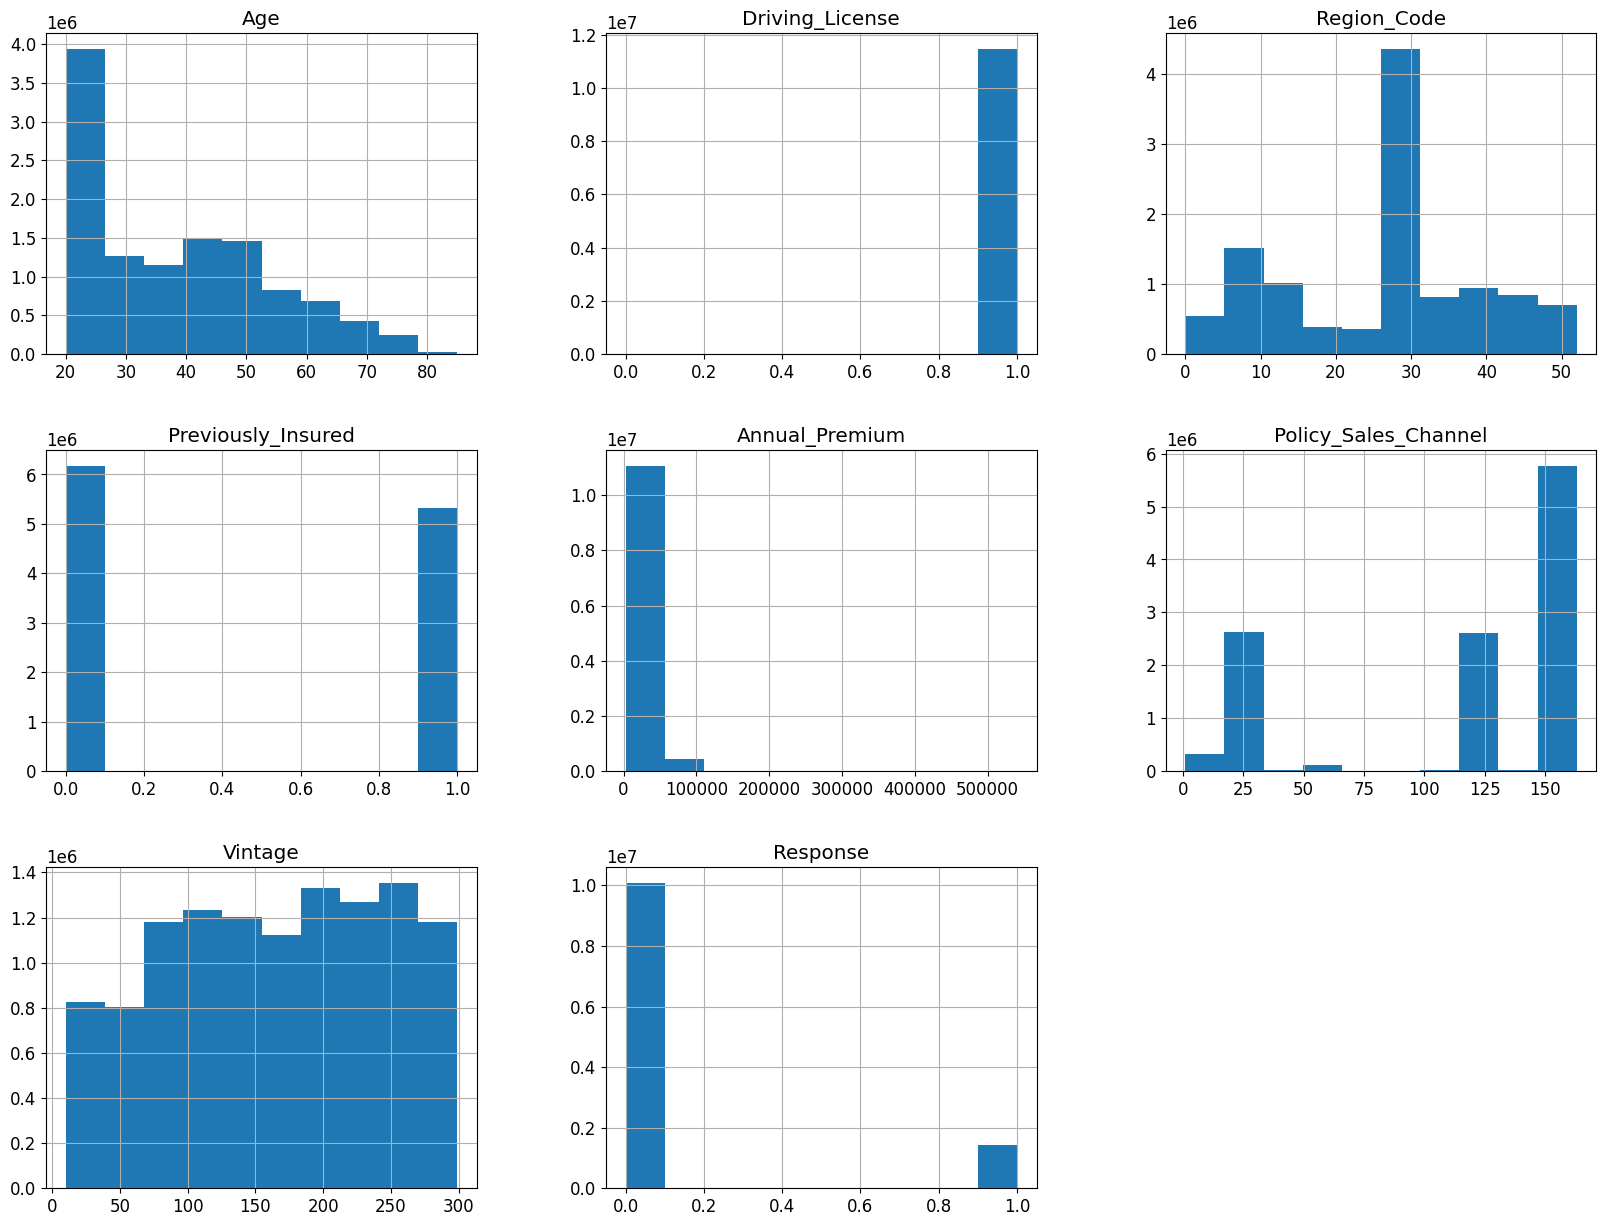

In [28]:
train_df.hist(figsize=(20,15));

In [29]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


In [30]:
train_df.describe(include=[object])

,Gender,Vehicle_Age,Vehicle_Damage
count,11504798,11504798,11504798
unique,2,3,2
top,Male,1-2 Year,Yes
freq,6228134,5982678,5783229


### Target

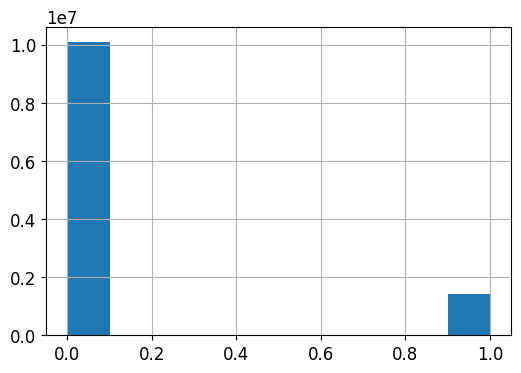

In [31]:
train_df['Response'].hist(figsize=(6,4));

In [32]:
train_df['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [33]:
train_df['Response'].unique()

array([0, 1])

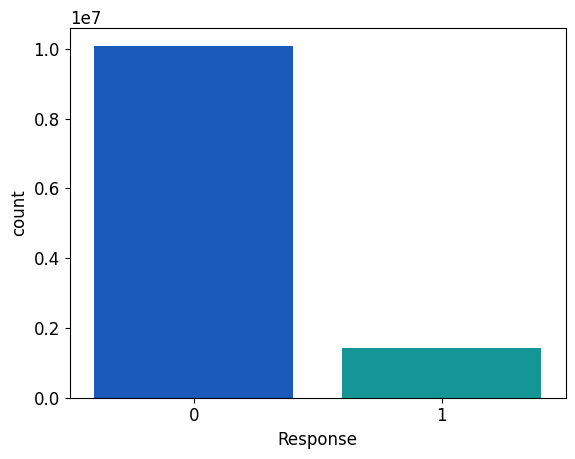

<Figure size 600x400 with 0 Axes>

In [34]:
#barplot
sns.countplot(x='Response', data=train_df, palette='winter')
plt.figure(figsize=(6, 4)) ;
plt.show();

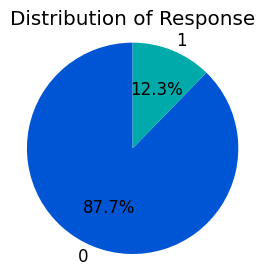

In [35]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# Count the occurrences of each response
response_counts = train_df['Response'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
colors = sns.color_palette('winter', n_colors=len(response_counts))
plt.pie(response_counts.values, labels=response_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Response')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

The target variable is imbalanced heavily skewing towards 0 which represents a no.

### Categorical Variables

In [36]:
cat_names

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

#### Vehicle Damage

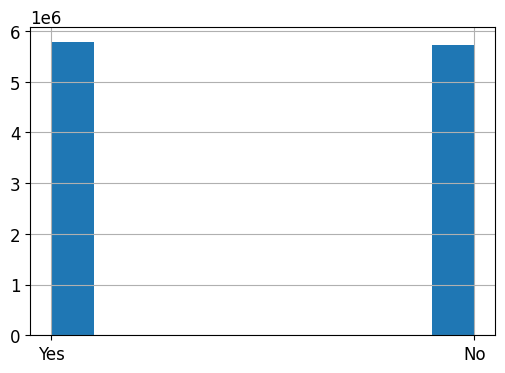

In [37]:
train_df['Vehicle_Damage'].hist(figsize=(6,4));

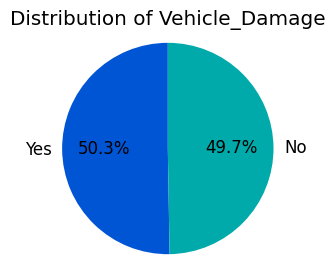

In [38]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# Count the occurrences of each response
vd_counts = train_df['Vehicle_Damage'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
colors = sns.color_palette('winter', n_colors=len(vd_counts))
plt.pie(vd_counts.values, labels=vd_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Vehicle_Damage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [39]:
contingency_table = pd.crosstab(train_df['Vehicle_Damage'], train_df['Response'])
print(contingency_table)

Response              0        1
Vehicle_Damage                  
No              5697548    24021
Yes             4392191  1391038


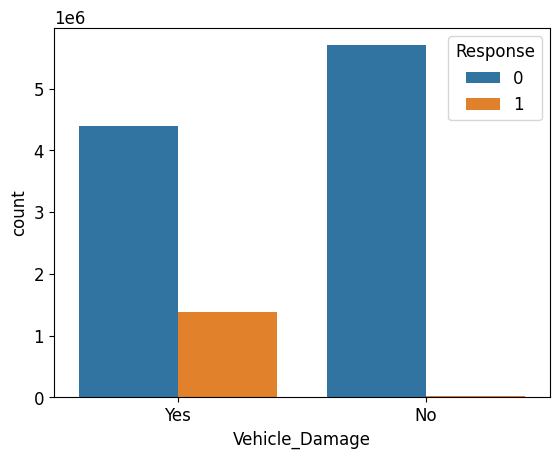

In [40]:
sns.countplot(x='Vehicle_Damage', hue='Response', data=train_df)
plt.show()

#### Gender

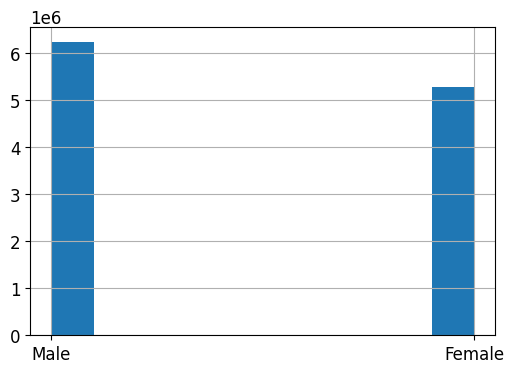

In [64]:
train_df['Gender'].hist(figsize=(6,4));

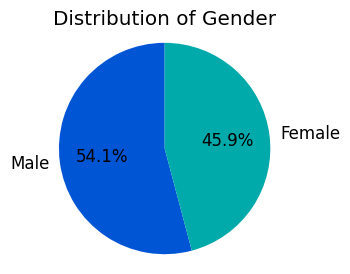

In [65]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# Count the occurrences of each response
gender_counts = train_df['Gender'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
colors = sns.color_palette('winter', n_colors=len(gender_counts))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

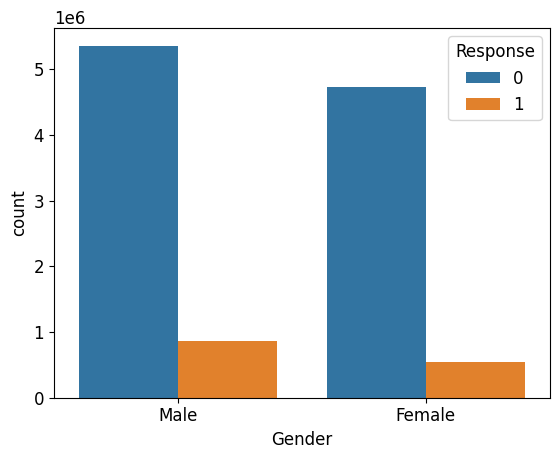

In [62]:
sns.countplot(x='Gender', hue='Response', data=train_df)
plt.show()

### Continous Variables

In [52]:
cont_names

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

#### Age

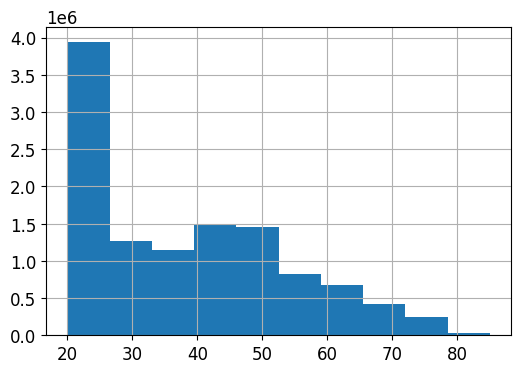

In [53]:
train_df['Age'].hist(figsize=(6,4));

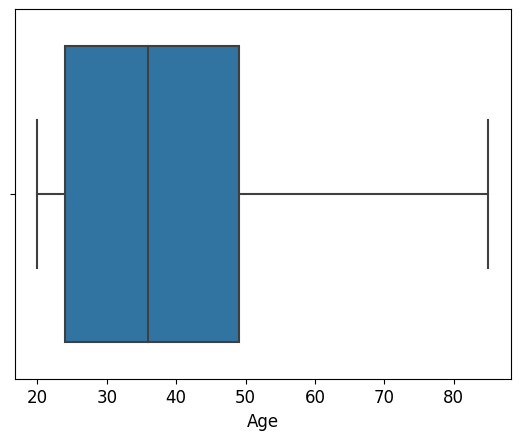

In [54]:
sns.boxplot(x='Age', data=train_df)
plt.show()
plt.close()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

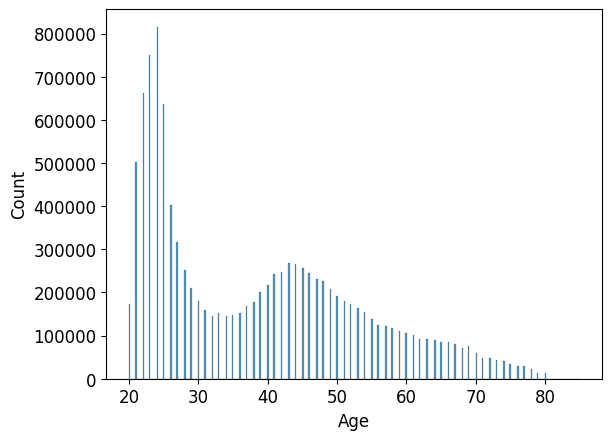

In [55]:
sns.histplot(x = 'Age', data = train_df)

In [56]:
train_df.Age.mean()

38.38356336199905

In [57]:
trim_mean(train_df.Age, proportiontocut=0.1) 

36.85232066181072

In [58]:
train_df.Age.median()

36.0

In [59]:
train_df.Age.mode()

0    24
Name: Age, dtype: int64

Outlier check

In [60]:
train_df.Age.var()


224.80379804254449

### Correlation

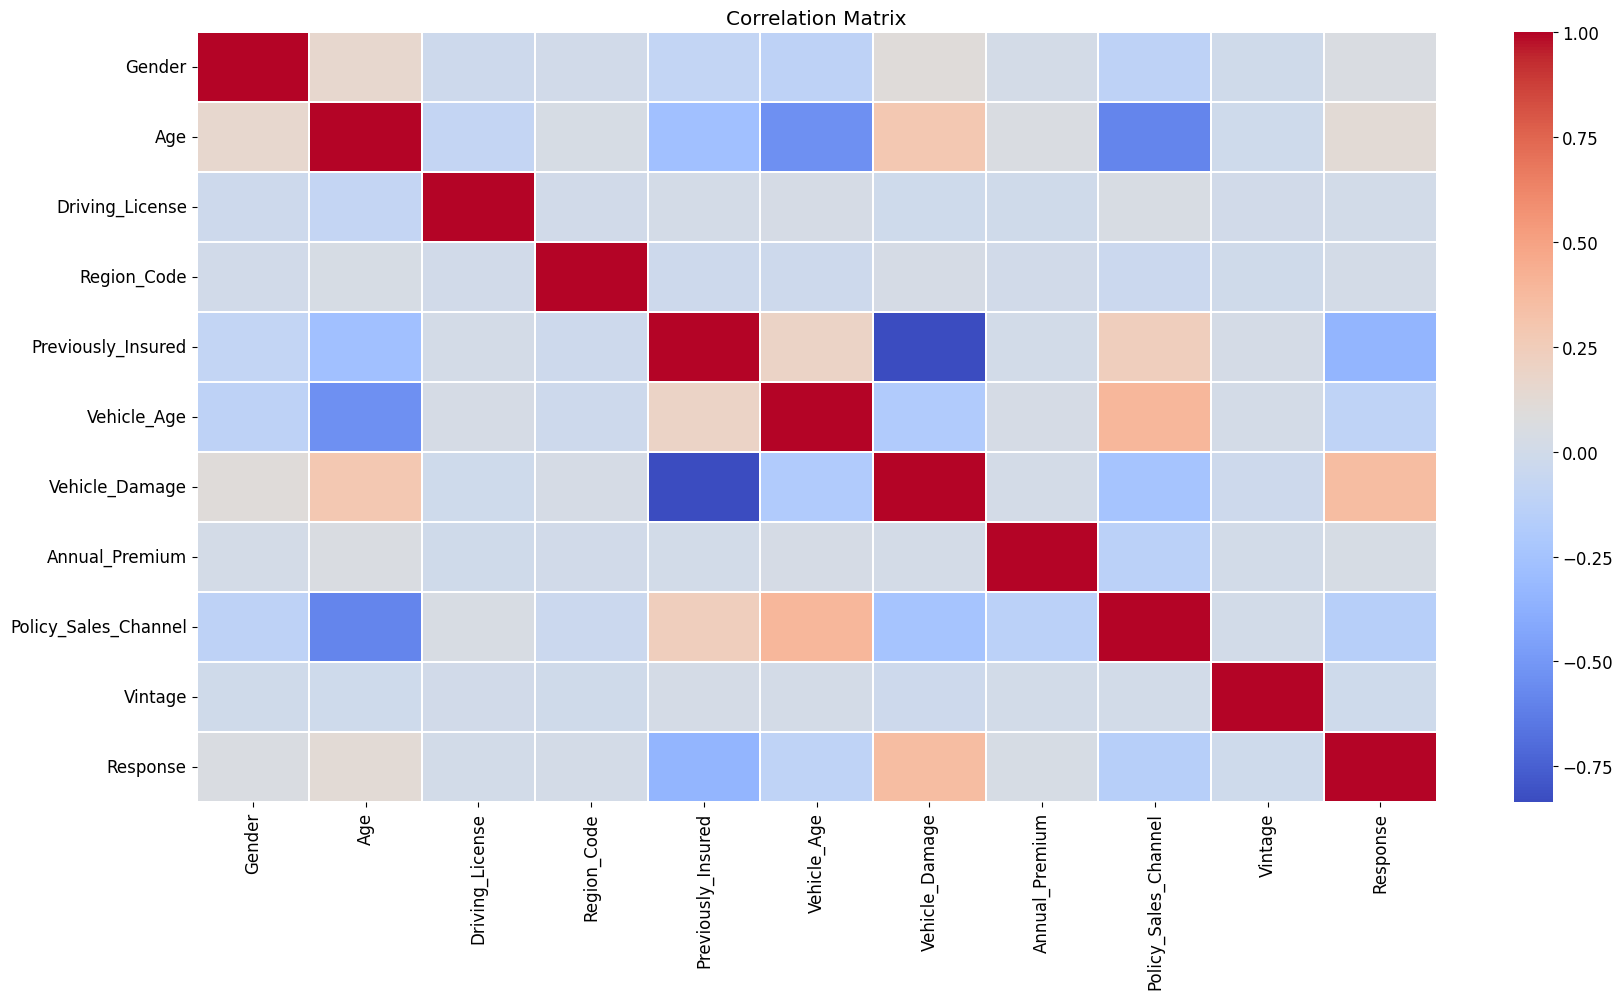

In [61]:
# Extract data from fastai DataLoaders
df = pd.DataFrame(dls.train.dataset.items)

# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Replace inf values with NaN if any
#numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Create the plot
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

#### Theories

From the correlation matrix, i infer that vehicle damage and Age have a heavy influence on the Response.
We notice that people with vehicle damage are way more likely to buy car insuarance.

# Neural Network

In [ ]:
learn = tabular_learner(dls, metrics=RocAucBinary())

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(8,0.005)


In [ ]:
dl = test_dl
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Response'] = nn_preds_proba
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

# Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(5, 0.005)
    return learn.get_preds(test_dl=test_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

# Random Forest

In [ ]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

#mse = mean_absolute_error(y_test, rf_preds_x)
#rmse = np.sqrt(mse)

#accuracy_score(y_test,rf_preds_x)
roc_auc_score(y_test,rf_preds_x)

In [ ]:
#RandomForestClassifier??

## Feature Importance

# Gradient Boosting

# XGBoost

In [ ]:
print(xgb.get_config())

In [ ]:
xgb_params = {
              
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'n_estimators': 1500,       
    'learning_rate': 0.55,                   
    'min_child_weight': 17,      
    'reg_lambda': 0.2,           
    'reg_alpha': 7,              
    'max_bin': 52000,            
    'colsample_bytree': 0.65,    
    'max_delta_step': 2,         
    'random_state': 0,
    'tree_method': 'hist'
}


In [ ]:
%%time
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))
xgb_preds_proba = tensor(xgb_model.predict_proba(test_dl.xs))[:, 1]

xgb_preds_x = tensor(xgb_model.predict(X_test))
xgb_preds_x_proba = tensor(xgb_model.predict_proba(X_test))[:, 1]

xgb_score = roc_auc_score(y_test,xgb_preds_x_proba)
xgb_score

In [ ]:
!ls

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Response'] = xgb_preds_proba
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

## Optuna

In [ ]:
%%time
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 30),  
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'max_bin': trial.suggest_int('max_bin', 40000, 60000),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'device_type': 'gpu'
        
    }

    model =  xgb.XGBClassifier(**params, random_state=0)
    
    # Cross-validation with 5 folds using KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    
    # We maximize accuracy, so we return the mean accuracy of the cross-validation
    return np.mean(cv_results)

study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-07-22 21:56:16,441] A new study created in memory with name: no-name-cd65710a-c59f-430d-b5c0-a49c795f0eba
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:56:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "device_type", "min_child_samples", "num_leaves", "subsample_for_bin" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:19:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "device_type", "min_child_samples", "num_leaves", "subsample_for_bin" } are not used.

  warnings.warn(smsg, UserWarning)


In [79]:
print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

ValueError: No trials are completed yet.

### Cross validation implementation

In [ ]:
#scores = cross_val_score(xgb_model,X_train, y_train,cv=5,scoring='roc_auc')
#scores.mean()

In [ ]:
%%time
f

K_FOLDS = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# This part is just to demonstrate how the indices work
for train_index, test_index in kfold.split(train_df):
    print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

fold_scores = []

for train_index, val_index in kfold.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    Xgb_model_fold = xgb.XGBClassifier(**xgb_params)
    Xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities on the validation set for the current fold
    y_pred_fold = Xgb_model_fold.predict_proba(X_fold_val)[:, 1]
    y_pred_fold_tt = Xgb_model_fold.predict_proba(test_dl.xs)[:, 1]
    
    # Calculate and store the AUC-ROC score for the current fold
    score = roc_auc_score(y_fold_val, y_pred_fold)
    fold_scores.append(score)

# Calculate the average score across all folds
avg_score = np.mean(fold_scores)
print(f"Average AUC-ROC Score Across All Folds: {avg_score}")

In [ ]:
y_pred_fold_tt.shape

In [ ]:
avg_score

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Response'] = y_pred_fold_tt
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

In [ ]:
xgb_model = xgb.XGBClassifier(alpha=0.2271025051979102,
                    gamma=0.07819541270693704,
                    eta=0.294535700691525,
                    max_depth=15,
                    max_bin=174857,
                    min_child_weight=1,
                    max_child_weight=10,
                    n_estimators=9500,
                    subsample=0.8362024536878123,
                    tree_method="hist",
                    device="cuda",
                    use_label_encoder=False,
                    enable_categorical=True,
                    eval_metric='auc',
                    objective='binary:logistic',
                    colsample_bytree=0.42784607351667425)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

#accuracy_score(y_test,xgb_preds_x)
xgb_score = roc_auc_score(y_test,xgb_preds_x)
xgb_score

# LightGBM

In [ ]:
lgbm_params = {'n_estimators': 1190, 'learning_rate': 0.22952000374471332, 'max_depth': 13, 'reg_alpha': 8.200152384535924,
          'reg_lambda': 4.285393733702208, 
          'num_leaves': 100, 'subsample': 0.6497981764924947, 'colsample_bytree': 0.37368304607248115,\
               'device_type':'gpu'}

In [ ]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds_prob = tensor(lgbm_model.predict_proba(test_dl.xs))
lgbm_positive_preds = (lgbm_preds_prob[:, 1])

#validation set preds
lgbm_preds_x = tensor(lgbm_model.predict(X_test))
lgbm_preds_x_prob = tensor(lgbm_model.predict_proba(X_test))
lgbm_positive_preds_x = (lgbm_preds_x_prob[:, 1])

lgbm_score = roc_auc_score(y_test,lgbm_positive_preds_x)
lgbm_score

#lgb_preds_x_prob = tensor(lgb_model.predict_proba(X_test))

lgbm_score_prob = roc_auc_score(y_test,lgbm_positive_preds_x)
lgbm_score_prob


In [ ]:
lgbm_score_prob

In [ ]:
%%time

K_FOLDS = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# This part is just to demonstrate how the indices work
for train_index, test_index in kfold.split(train_df):
    print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

fold_scores = []

for train_index, val_index in kfold.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    lgb_model_fold = lgb.LGBMClassifier(**params)
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities on the validation set for the current fold
    y_pred_fold = lgb_model_fold.predict_proba(X_fold_val)[:, 1]
    y_pred_fold_tt = lgb_model_fold.predict_proba(test_dl.xs)[:, 1]
    
    # Calculate and store the AUC-ROC score for the current fold
    score = roc_auc_score(y_fold_val, y_pred_fold)
    fold_scores.append(score)

# Calculate the average score across all folds
avg_score = np.mean(fold_scores)
print(f"Average AUC-ROC Score Across All Folds: {avg_score}")

## Hyperparamter optimization with Optuna

In [ ]:
# finetuned optuna code
%%time

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []
    
    #for train_index, test_index in kfold.split(train_df):
    #print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        lgb_model_fold = lgb.LGBMClassifier(**params)  # Use params, not lgbm_params
        lgb_model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities on the validation set for the current fold
        y_pred_fold = lgb_model_fold.predict_proba(X_fold_val)[:, 1]
        
        # Calculate and store the AUC-ROC score for the current fold
        score = roc_auc_score(y_fold_val, y_pred_fold)
        fold_scores.append(score)
    
    # Calculate the average score across all folds
    return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

In [ ]:
print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

In [ ]:
lgbm_optuna_run2_params  =  {
    'num_leaves': 320, 
    'learning_rate': 0.13981961408994045, 
    'n_estimators': 843,
    'subsample_for_bin': 172567, 
    'min_child_samples': 223,
    'reg_alpha': 0.0028770084050677926,
    'reg_lambda': 2.3761404778025532e-05,
    'colsample_bytree': 0.9350638004692479,
    'subsample': 0.9727470703757719,
    'max_depth': 6,
    'device_type':'gpu'
}

### With Optuna tuned parameters

In [ ]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier(**lgbm_optuna_run2_params)
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds_prob = tensor(lgbm_model.predict_proba(test_dl.xs))
lgbm_positive_preds = (lgbm_preds_prob[:, 1])

#validation set preds
lgbm_preds_x = tensor(lgbm_model.predict(X_test))
lgbm_preds_x_prob = tensor(lgbm_model.predict_proba(X_test))
lgbm_positive_preds_x = (lgbm_preds_x_prob[:, 1])

lgbm_score = roc_auc_score(y_test,lgbm_positive_preds_x)
lgbm_score

#lgb_preds_x_prob = tensor(lgb_model.predict_proba(X_test))

lgbm_score_prob = roc_auc_score(y_test,lgbm_positive_preds_x)
lgbm_score_prob


In [ ]:
lgbm_score_prob


In [ ]:
%%time

K_FOLDS = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# This part is just to demonstrate how the indices work
for train_index, test_index in kfold.split(train_df):
    print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

fold_scores = []

for train_index, val_index in kfold.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    lgb_model_fold = lgb.LGBMClassifier(**lgbm_optuna_run2_params)
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities on the validation set for the current fold
    y_pred_fold = lgb_model_fold.predict_proba(X_fold_val)[:, 1]
    y_pred_fold_tt = lgb_model_fold.predict_proba(test_dl.xs)[:, 1]
    
    # Calculate and store the AUC-ROC score for the current fold
    score = roc_auc_score(y_fold_val, y_pred_fold)
    fold_scores.append(score)

# Calculate the average score across all folds
avg_score = np.mean(fold_scores)
print(f"Average AUC-ROC Score Across All Folds: {avg_score}")

In [ ]:
avg_score

# CatBoost

In [ ]:
cat_optuna_params = {
    
    'colsample_bylevel': 0.6383474716497279,
    'learning_rate': 0.09475494290429642,
    'random_strength': 0.07771221926568195,
    'max_bin': 490,
    'depth': 5,
    'l2_leaf_reg': 5,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8429457747642737,
    'task_type': 'GPU'
    
}

In [ ]:
%%time
cat_model = CatBoostClassifier(**cat_optuna_params)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


#cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

#cat_preds_x_final = cat_preds_x.squeeze(1)

#accuracy_score(y_test,cat_preds_x)

cat_score = roc_auc_score(y_test,cat_preds_x)
cat_score

# Model Predictions

In [ ]:
model_preds = {
    "random forests":roc_auc_score(y_test,rf_preds_x),
    "cat boost":cat_score,
    "lgbm":lgb_score,
    "xgboost":roc_auc_score(y_test,xgb_preds_x),   
}

#model_preds_a = model_preds.sort()
print(model_preds)

In [ ]:
cat_preds_x

# Model Ensemble

# Submission

In [ ]:
!ls

In [ ]:
lgbm_preds_final = (lgbm_preds_prob[:, 1])

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Response'] = lgbm_preds_final 
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

In [ ]:
!ls